# Import Required Libraries

In [1]:
import numpy as np 
import pandas as pd
from zipfile import ZipFile 
from nltk.stem import WordNetLemmatizer
from nltk import TweetTokenizer, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from string import punctuation
punctuation = punctuation.replace("'", "")
import string
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Import Data

In [2]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

train_text = df_train['comment_text']
test_text = df_test['comment_text']
all_text = pd.concat([train_text, test_text])

# Removing Punctuations and Tokenizing Data

In [3]:
def remove_punc(row):
    return row.translate(str.maketrans('', '', string.punctuation))
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def stemming(input_str):    
    wordnet_lemmatizer = WordNetLemmatizer()
    string = ''
    tknzr = TweetTokenizer()
    input_str = tknzr.tokenize(input_str)
    for word,pos in pos_tag(input_str):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        string += (wordnet_lemmatizer.lemmatize(word, pos=wordnet_pos)) + ' '
    return string.strip()

In [4]:
stemmed = all_text.apply(remove_punc)

In [5]:
stemmed = stemmed.apply(stemming)

# Using Vectorization to get important features

In [6]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    min_df = .005,
    max_df = .9,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 4),
    max_features=10000)

In [7]:
word_vectorizer.fit(stemmed)
train_word_features = word_vectorizer.transform(train_text)

In [8]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

In [9]:
char_vectorizer.fit(stemmed)
train_char_features = char_vectorizer.transform(train_text)

## Combining word and character features

In [10]:
train_features = hstack([train_char_features, train_word_features])
# test_features = hstack([test_char_features, test_word_features])

In [ ]:
data = train_features.toarray()

## Logistic Regression

In [12]:
scores = []

for class_name in class_names:
    train_target = df_train[class_name]
    classifier = LogisticRegression(C=1, solver='sag')
    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    

CV score for class toxic is 0.9717211658352101
CV score for class severe_toxic is 0.986284753777031
CV score for class obscene is 0.9862020337284122
CV score for class threat is 0.98578703997725
CV score for class insult is 0.978333687212639
CV score for class identity_hate is 0.9782368172205643


### Generating ROC-AUC Curves

In [11]:
# for class_name in class_names:
#     train_target = df_train[class_name]
#     classifier = LogisticRegression(C=1, solver='sag')
#     classifier.fit(train_features[:120000], train_target[:120000])
#     y_pred = classifier.predict_proba(train_features[-30000:])
#     fpr_keras, tpr_keras, thresholds_keras = roc_curve(train_target[-30000:], y_pred)
    
#     plt.figure(1)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#     # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     plt.show()

## Mean ROC_AUC Score:

In [13]:
np.mean(scores)

0.9810942496251843

In [76]:
# coeff = classifier.coef_[0].tolist()
# list_ = []
# for i, imp in enumerate(coeff):
#     list_.append((i, imp))
# sort_list_ = sorted(list_, key = lambda x:x[1], reverse = True)
# indices = [x for x, y in sort_list_[:10]]
# imp_features = np.array(features)[indices]
# imp_coeff = np.array(coeff)[indices]

# plt.title('Feature Importances')
# plt.barh(range(len(indices)), imp_coeff, color='b', align='center')
# plt.yticks(range(len(indices)), imp_features)
# plt.xlabel('Relative Importance')
# plt.show()

# Random Forest

In [15]:
rf_scores = []
for class_name in class_names:
    train_target = df_train[class_name]
    random_classifier = RandomForestClassifier(max_depth=3, n_estimators = 2000)
    random_classifier.fit(train_features, train_target)
    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))
    rf_scores.append(cv_score)
    

CV score for class toxic is 0.971720911594567
CV score for class severe_toxic is 0.9862848967408576
CV score for class obscene is 0.9862019937776703
CV score for class threat is 0.9857873167031728
CV score for class insult is 0.978333782608899
CV score for class identity_hate is 0.9782368444413079


In [16]:
np.mean(rf_scores)

0.9810942909777457

#### It is clear from the results that the logistic regression and random forest give very similar AUC scores. However we will use the Logistic Regression algorithm due to a much smaller runtime.

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical 

Using TensorFlow backend.


In [16]:
data.shape

(159571, 10848)

In [71]:
model = Sequential()
    # model.add(Flatten())
model.add(Dense(2000, activation='relu', input_dim=10832))
    # model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
# model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
train_target = df_train['toxic']
model.fit(data[:145000], train_target[:145000], epochs=5)

Epoch 1/5
145000/145000 [==============================] - 1325s 9ms/step - loss: 0.1235 - accuracy: 0.9566
Epoch 2/5
145000/145000 [==============================] - 1306s 9ms/step - loss: 0.0935 - accuracy: 0.9662
Epoch 3/5
145000/145000 [==============================] - 3426s 24ms/step - loss: 0.0438 - accuracy: 0.9847
Epoch 4/5
145000/145000 [==============================] - 1390s 10ms/step - loss: 0.0135 - accuracy: 0.9961
Epoch 5/5
145000/145000 [==============================] - 1353s 9ms/step - loss: 0.0097 - accuracy: 0.9968


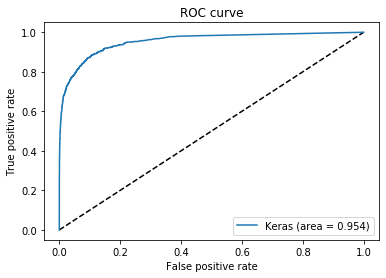

In [74]:
y_pred = model.predict_proba(data[-10000:])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(train_target[-10000:], y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [75]:
auc_keras

0.9542848777136808